In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


## Load dataset

In [2]:
!ls

datalab  drive


In [0]:
import numpy as np
import cv2

images_train = np.load('/content/drive/cropped_eyes_training.npy')
cls_train = np.load('/content/drive/cropped_eyes_training_scores.npy')

images_test = np.load('/content/drive/cropped_eyes_testing.npy')
cls_test = np.load('/content/drive/cropped_eyes_testing_scores.npy')

for i in range(len(images_train)):
  images_train[i] = (cv2.resize(images_train[i], dsize=(384, 128))).tolist()
  
for i in range(len(images_test)):
  images_test[i] = cv2.resize(images_test[i], dsize=(384, 128))
  
y_train = np.asarray(cls_train)
y_test = np.asarray(cls_test)

X_train = images_train
X_test = images_test

X_train = np.asarray(X_train.tolist())
X_test = np.asarray(X_test.tolist())

images_test = X_test
images_train = X_train
cls_train = y_train
cls_test = y_test

In [4]:
y_train.shape

(953, 2)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

## Define model

In [0]:
import tensorflow as tf

slim = tf.contrib.slim
trunc_normal = lambda stddev: tf.truncated_normal_initializer(stddev=stddev)

In [0]:
def eyenet_arg_scope(weight_decay=0.004, is_training=True):
    
  with slim.arg_scope(
      [slim.conv2d],
      weights_initializer=tf.truncated_normal_initializer(stddev=5e-2),
      activation_fn=tf.nn.relu):
    with slim.arg_scope(
        [slim.fully_connected],
        biases_initializer=tf.constant_initializer(0.1),
        weights_initializer=trunc_normal(0.04),
        weights_regularizer=slim.l2_regularizer(weight_decay),
        normalizer_fn=None,
        activation_fn=tf.nn.relu) as sc:
      return sc


In [0]:
def eyecropnet_arg_scope_bnorm(weight_decay=0.004, is_training=True):
  
  batch_norm_params = {
      'is_training': is_training,
      'center': True,
      'scale': True,
      'decay': 0.997,
      'epsilon': 0.001,
  }
  
  with slim.arg_scope(
      [slim.conv2d],
      # weights_initializer=tf.truncated_normal_initializer(stddev=5e-2),
      weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
      activation_fn=tf.nn.relu6,
      normalizer_fn=slim.batch_norm):
    with slim.arg_scope([slim.batch_norm], **batch_norm_params):
      with slim.arg_scope(
          [slim.fully_connected],
          biases_initializer=tf.constant_initializer(0.1),
          # weights_initializer=trunc_normal(0.04),
          weights_initializer=tf.contrib.layers.xavier_initializer(),
          weights_regularizer=slim.l2_regularizer(weight_decay),

          activation_fn=tf.nn.relu) as sc:
         
          return sc


In [0]:
trunc_normal = lambda stddev: tf.truncated_normal_initializer(stddev=stddev)

def eyecropnet_bn(images, num_classes=2, is_training=False,
             dropout_keep_prob=0.5,
             prediction_fn=tf.identity, # slim.softmax,
             scope='EyeCropNet'):
 
  end_points = {}

  with tf.variable_scope(scope, 'EyeCropNet', [images]):
    
    net = slim.conv2d(images, 32, [3, 3], stride=2, padding='SAME')
    net = slim.separable_conv2d(net, None, [3,3], stride=1, depth_multiplier=1, padding = 'SAME')
#     net = tf.nn.depthwise_conv2d(net, [3, 3, 32, 1], strides = [1,1,1,1], padding = 'SAME')
    
    net = slim.conv2d(net, 64, [1, 1], stride=1, padding='SAME')
    net = slim.separable_conv2d(net, None, [3,3], stride=2, depth_multiplier=1, padding = 'SAME')
#     net = tf.nn.depthwise_conv2d(net, [3, 3, 64, 1], strides = [1,2,2,1], padding = 'SAME')
    
    net = slim.conv2d(net, 128, [1, 1], stride=1, padding='SAME')
    net = slim.separable_conv2d(net, None, [3,3], stride=1, depth_multiplier=1, padding = 'SAME')
#     net = tf.nn.depthwise_conv2d(net, [3, 3, 128, 1], strides = [1,1,1,1], padding = 'SAME')
    
    net = slim.conv2d(net, 128, [1, 1], stride=1, padding='SAME')
    net = slim.separable_conv2d(net, None, [3,3], stride=2, depth_multiplier=1, padding = 'SAME')
#     net = tf.nn.depthwise_conv2d(net, [3, 3, 128, 1], strides = [1,2,2,1], padding = 'SAME')
    
    net = slim.conv2d(net, 256, [1, 1], stride=1, padding='SAME')
    net = slim.separable_conv2d(net, None, [3,3], stride=1, depth_multiplier=1, padding = 'SAME')
#     net = tf.nn.depthwise_conv2d(net, [3, 3, 256, 1], strides = [1,1,1,1], padding = 'SAME')
    
    net = slim.conv2d(net, 256, [1, 1], stride=1, padding='SAME')
    net = slim.separable_conv2d(net, None, [3,3], stride=2, depth_multiplier=1, padding = 'SAME')
#     net = tf.nn.depthwise_conv2d(net, [3, 3, 256, 1], strides = [1,2,2,1], padding = 'SAME')
    
    net = slim.conv2d(net, 512, [1, 1], stride=1, padding='SAME')
    
    net = slim.separable_conv2d(net, None, [3,3], stride=1, depth_multiplier=1, padding = 'SAME')
####     net = tf.nn.depthwise_conv2d(net, [3, 3, 512, 1], strides = [1,1,1,1], padding = 'SAME')
###    net = slim.conv2d(net, 512, [1, 1], stride=1, padding='SAME')
###    net = slim.separable_conv2d(net, None, [3,3], stride=1, depth_multiplier=1, padding = 'SAME')
####     net = tf.nn.depthwise_conv2d(net, [3, 3, 512, 1], strides = [1,1,1,1], padding = 'SAME')
###    net = slim.conv2d(net, 512, [1, 1], stride=1, padding='SAME')
###    net = slim.separable_conv2d(net, None, [3,3], stride=1, depth_multiplier=1, padding = 'SAME')
####     net = tf.nn.depthwise_conv2d(net, [3, 3, 512, 1], strides = [1,1,1,1], padding = 'SAME')
###    net = slim.conv2d(net, 512, [1, 1], stride=1, padding='SAME')
###    net = slim.separable_conv2d(net, None, [3,3], stride=1, depth_multiplier=1, padding = 'SAME')
####     net = tf.nn.depthwise_conv2d(net, [3, 3, 512, 1], strides = [1,1,1,1], padding = 'SAME')
###    net = slim.conv2d(net, 512, [1, 1], stride=1, padding='SAME')
###    net = slim.separable_conv2d(net, None, [3,3], stride=1, depth_multiplier=1, padding = 'SAME')
####     net = tf.nn.depthwise_conv2d(net, [3, 3, 512, 1], strides = [1,1,1,1], padding = 'SAME')
    net = slim.conv2d(net, 512, [1, 1], stride=1, padding='SAME')
    
    net = slim.separable_conv2d(net, None, [3,3], stride=2, depth_multiplier=1, padding = 'SAME')
#     net = tf.nn.depthwise_conv2d(net, [3, 3, 512, 1], strides = [1,2,2,1], padding = 'SAME')
    net = slim.conv2d(net, 1024, [1, 1], stride=1, padding='SAME')
    
    net = slim.separable_conv2d(net, None, [3,3], stride=1, depth_multiplier=1, padding = 'SAME') #stride = 2
#     net = tf.nn.depthwise_conv2d(net, [3, 3, 1024, 1], strides = [1,2,2,1], padding = 'SAME')
    net = slim.conv2d(net, 1024, [1, 1], stride=1, padding='SAME')
    
    net = slim.avg_pool2d(net, [4, 12], stride=1)
    end_points['avgpool'] = net
    
    net = slim.flatten(net)
    end_points['flatten'] = net

    net = slim.dropout(net, dropout_keep_prob, is_training=is_training)
    
    logits = slim.fully_connected(net, num_classes,
                                  biases_initializer=tf.zeros_initializer(),
                                  # weights_initializer=trunc_normal(1/50.0),
                                  weights_initializer=tf.contrib.layers.xavier_initializer(),
                                  weights_regularizer=None,
                                  activation_fn=None,
                                  scope='logits')
    
    logits = tf.identity(logits, name='eye_coordinates')
    
    end_points['Logits'] = logits
    end_points['Predictions'] = prediction_fn(logits)

  return logits, end_points

In [0]:
# parametri de training si input
batch_size = 12
height = 128
width = 384
channels = 3
num_classes = 2
initial_learning_rate = 1e-4

### Adaugarea conexiunilor de intrare. tf.placeholders

In [0]:
    import random    
    
    def add_preprocessing(image_input, is_training):
      
#        def _process_image(image):
#            # Because these operations are not commutative, consider randomizing
#            # randomize the order their operation.
            
#            augment_level = random.randint(0,3)
#            if augment_level > 0:
#                image = tf.image.random_brightness(image, max_delta=30)
#                image = tf.image.random_contrast(image, lower=0.75, upper=1.25)
#            if augment_level > 1:
#                image = tf.image.random_saturation(image, lower=0.5, upper=1.6)
#                image = tf.image.random_hue(image, max_delta=0.15)
#            image = tf.minimum(image, 255.0)
#            image = tf.maximum(image, 0)
#            return image

        def _process_image(image):
            # Because these operations are not commutative, consider randomizing
            # randomize the order their operation.

            augment_level = random.randint(0,2)

            if augment_level > 0:
                r = random.randint(0,1)
                if r == 1:
                  image = tf.image.random_brightness(image, max_delta=30)
                  # image = tf.image.random_contrast(image, lower=0.75, upper=1.25)
                else:
                  # image = tf.image.random_contrast(image, lower=0.75, upper=1.25)
                  image = tf.image.random_brightness(image, max_delta=30)
            if augment_level > 1:
                r = random.randint(0,1)
                if r == 1:
                  image = tf.image.random_saturation(image, lower=0.5, upper=1.6)
                  image = tf.image.random_hue(image, max_delta=0.15)
                else:
                  image = tf.image.random_hue(image, max_delta=0.15)
                  image = tf.image.random_saturation(image, lower=0.5, upper=1.6)

            image = tf.minimum(image, 255.0)
            image = tf.maximum(image, 0)
            return image

        def _preprocess_train(input_tensor):
#             input_tensor = tf.image.random_flip_left_right(input_tensor)
#             input_tensor = input_tensor * 255.0
            input_tensor = _process_image(input_tensor)
#             input_tensor = tf.scalar_mul(1.0 / 255, input_tensor)

            input_tensor = tf.subtract(input_tensor, 0.5)
            input_tensor = tf.multiply(input_tensor, 2.0)
            # input_tensor = tf.Print(input_tensor, [], "there")

#             cropped_input_tensor = tf.random_crop(input_tensor, [28,28,3])
      
#             return cropped_input_tensor
            return input_tensor
          
        def _preprocess_test(input_tensor):
            # input_tensor = tf.scalar_mul(1.0 / 255, input_tensor)
            input_tensor = tf.subtract(input_tensor, 0.5)
            input_tensor = tf.multiply(input_tensor, 2.0)
            # input_tensor = tf.Print(input_tensor, [], "here")
            
#             cropped_input_tensor = tf.image.central_crop(input_tensor, 0.875)
            
  
#             cropped_input_tensor = input_tensor[2:30,2:30,:]
#             return cropped_input_tensor
            return input_tensor
          
        preprocessed_input = tf.map_fn(lambda img:
                                 tf.cond(
                                   tf.equal(
                                        is_training,
                                     tf.constant(True)),
                                    lambda: _preprocess_train(img),
                                    lambda: _preprocess_test(img)), image_input)

        return preprocessed_input
          
        
    def add_placeholders():
              # image batch input
        image_input = tf.placeholder(
            tf.float32, [None, None, None, 3],
            name='image_input'
        )
        
        image_input = tf.image.resize_images(image_input, [height, width])

        label_input = tf.placeholder(
            tf.int64, [None, 2],
            name='label_input'
        )
        
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        learning_rate = tf.placeholder(tf.float32, shape=[])
        
        return image_input, label_input, is_training, learning_rate


In [0]:
def random_batch(img, labels, bsize=32):
    # Number of images in the training-set.
    num_images = len(img)
    #     print(num_images)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=bsize,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = img[idx, :, :, :]
    y_batch = labels[idx]

    return x_batch, y_batch

In [14]:
print(X_train[0,1,2,1])

x, y = random_batch(X_train, y_train)

y.shape

130


(32, 2)

In [15]:
def get_batch(imgs, labels, step, bsize=32):
  offset = (step * batch_size) % (labels.shape[0] - batch_size)
#   print(offset)
  batch_imgs = imgs[offset:(offset + bsize), :, :, :]
  batch_labels = labels[offset:(offset + bsize)]
  
  return batch_imgs, batch_labels
  
batch_imgs, batch_labels = get_batch(images_test, cls_test, 2)
  
print(batch_imgs.shape)
print(batch_labels.shape)
  

(32, 128, 384, 3)
(32, 2)


### Functie pentru evaluare acuratete

In [0]:
#evaluate model


def evaluate():
  bsize = 32
  total_examples = cls_test.shape[0]  
  iters = int(total_examples/bsize)
#   print("Total examples {}".format(total_examples))
#   print("Total iters {}".format(iters))
  
  
  acc = []
  losses = []
    
  for i in range(iters):
    
    x, y = get_batch(images_test, cls_test, i, bsize)

    feed_dict = {

        image_input: x,
        label_input: y,
        is_training: False

    }

    testAcc, testLoss = sess.run([accuracy, loss], feed_dict=feed_dict)
    acc.append(testAcc)
    losses.append(testLoss)
    if i % 100 == 0:
      print("Test " + str(i) + ": accuracy:" + str(testAcc) + " loss: " + str(testLoss))
    
      
#   print(acc)
  meanAcc = np.mean(np.asarray(acc))
  meanLoss = np.mean(np.asarray(losses))
  
#   print("Test Accuracy {:.2f} %".format(meanAcc * 100))
  
  return meanAcc, meanLoss
  
  
#evaluate()               


In [0]:
trainingAccuracyList = []
trainingLossList = []
testAccuracyList = []
testLossList = []
learningRateList = []

In [0]:
tf.reset_default_graph()

g = tf.Graph().as_default()
image_input, label_input, is_training, learning_rate = add_placeholders()
preprocessed_image_input = add_preprocessing(image_input, is_training)


arg_scope = eyenet_arg_scope_bnorm(is_training=is_training)
with slim.arg_scope(arg_scope):
  logits, end_points = eyenet_bn(preprocessed_image_input, is_training=is_training)

# scope = vgg.vgg_arg_scope()
# with slim.arg_scope(scope):
#    logits, end_points = vgg.vgg_16(image_input, num_classes=10, is_training=is_training)



In [19]:
# tf.reduce_mean(tf.squared_difference(tf.cast(logits, tf.float32), tf.cast(label_input, tf.float32)))
import tensorflow as tf
with tf.Session() as sess2:
  print(sess2.run(tf.squared_difference(tf.cast([[1, 2],[3,4]], tf.float32), tf.cast([[3, 5],[1,5]], tf.float32))))
  print(sess2.run(tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.squared_difference(tf.cast([[1, 2],[3,4]], tf.float32), tf.cast([[3, 5],[1,5]], tf.float32)), 1)))))
  print(sess2.run(tf.reduce_mean(tf.squared_difference(tf.cast([[1, 2],[3,4]], tf.float32), tf.cast([[3, 5],[1,5]], tf.float32)))))

[[4. 9.]
 [4. 1.]]
2.9208097
4.5


### Definirea pasilor de antrenare

In [20]:
initial_learning_rate = 1e-3
num_steps = int(200000)
num_examples = images_train.shape[0]
iters = num_examples / batch_size
learning_rate_step = 7000 # 10000
learning_rate_decay = .6 # 1

# loss = tf.reduce_mean(tf.squared_difference(tf.cast(logits, tf.float32), tf.cast(label_input, tf.float32)))
loss = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.squared_difference(tf.cast(logits, tf.float32), tf.cast(label_input, tf.float32)), 1)))

# accuracy of the trained model, between 0 (worst) and 1 (best)
predictions = end_points['Predictions']

correct_prediction = tf.equal(tf.argmax(predictions, 1), label_input)
accuracy = tf.constant(1) # tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Optimizer.
# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
  
init = tf.global_variables_initializer()

sess = tf.Session()

sess.run(init)
  
running_lr = initial_learning_rate

print("Starting optimization")
print("Batch size {}".format(batch_size))
print("Initial LR {}. LR stepdown itnerval {}. LR deacy factor {}".format(running_lr, learning_rate_step, learning_rate_decay))

for i in range(num_steps):
  x, y = random_batch(X_train, y_train, bsize=batch_size)

  feed_dict = {

      image_input: x,
      label_input: y,
      is_training: True,
      learning_rate : running_lr

  }

  if i % 200 == 0:
      _, trainAcc, trainLoss = sess.run([optimizer, accuracy, loss], feed_dict=feed_dict)
      
      testAcc, testLoss = evaluate()
      
      print("Train " + str(i) + ": accuracy:" + str(trainAcc) + " loss: " + str(trainLoss))
      print("Test " + str(i) + ": accuracy:" + str(testAcc) + " loss: " + str(testLoss))
      
      trainingAccuracyList.append(trainAcc)
      trainingLossList.append(trainLoss)
      testAccuracyList.append(testAcc)
      testLossList.append(testLoss)
      learningRateList.append(running_lr)
     
  else:
      sess.run([optimizer], feed_dict=feed_dict)
  
  
  if  i > 0 and i % learning_rate_step == 0:
      print("Learning reate step down. Old {}. New {}".format(running_lr, running_lr * learning_rate_decay))
      running_lr = running_lr * learning_rate_decay
      

Starting optimization
Batch size 12
Initial LR 0.001. LR stepdown itnerval 7000. LR deacy factor 0.6
Test 0: accuracy:1 loss: 13.515753
Train 0: accuracy:1 loss: 10.8085985
Test 0: accuracy:1.0 loss: 12.376549
Test 0: accuracy:1 loss: 13.509827
Train 200: accuracy:1 loss: 6.1687074
Test 200: accuracy:1.0 loss: 12.377831
Test 0: accuracy:1 loss: 13.512393
Train 400: accuracy:1 loss: 4.9548764
Test 400: accuracy:1.0 loss: 12.3796625
Test 0: accuracy:1 loss: 13.503624
Train 600: accuracy:1 loss: 4.216797
Test 600: accuracy:1.0 loss: 12.381419
Test 0: accuracy:1 loss: 13.479486
Train 800: accuracy:1 loss: 4.5419164
Test 800: accuracy:1.0 loss: 12.395993
Test 0: accuracy:1 loss: 13.427754
Train 1000: accuracy:1 loss: 5.728031
Test 1000: accuracy:1.0 loss: 12.438247
Test 0: accuracy:1 loss: 13.427192
Train 1200: accuracy:1 loss: 3.9815607
Test 1200: accuracy:1.0 loss: 12.438352
Test 0: accuracy:1 loss: 13.456881
Train 1400: accuracy:1 loss: 2.4535074
Test 1400: accuracy:1.0 loss: 12.757801
T

Test 0: accuracy:1 loss: 3.1341724
Train 17200: accuracy:1 loss: 1.0943534
Test 17200: accuracy:1.0 loss: 3.1341102
Test 0: accuracy:1 loss: 3.9570704
Train 17400: accuracy:1 loss: 0.98252726
Test 17400: accuracy:1.0 loss: 3.9192498
Test 0: accuracy:1 loss: 3.159268
Train 17600: accuracy:1 loss: 1.4683253
Test 17600: accuracy:1.0 loss: 3.283786
Test 0: accuracy:1 loss: 3.1818712
Train 17800: accuracy:1 loss: 1.2133391
Test 17800: accuracy:1.0 loss: 3.4108973
Test 0: accuracy:1 loss: 3.5200953
Train 18000: accuracy:1 loss: 0.9896404
Test 18000: accuracy:1.0 loss: 3.5025787
Test 0: accuracy:1 loss: 3.462864
Train 18200: accuracy:1 loss: 0.8481953
Test 18200: accuracy:1.0 loss: 3.4929168


KeyboardInterrupt: ignored

### Plotting

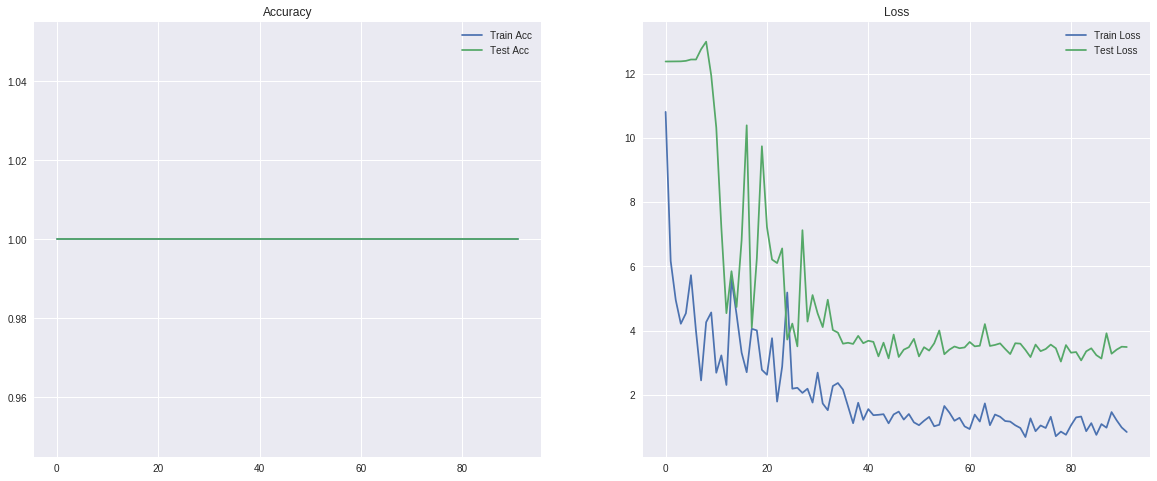

In [21]:
plt.figure(figsize=(20,8))

# Plot Accuracy
# plt.subplot(1,2,1);
# plt.plot(trainingAccuracyList, label="Train Acc");
# plt.plot(testAccuracyList, label="Test Acc");
# plt.title("Accuracy");
# plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList, label="Train Loss");
plt.plot(testLossList, label="Test Loss");
plt.title("Loss");
plt.legend();

## Evaluate final model

In [48]:
acc, test_loss = evaluate()

print("Test accuracy:" + str(acc) + " loss: " + str(test_loss))                   

Test 0: accuracy:1 loss: 7.689825
Test accuracy:1.0 loss: 12.87782


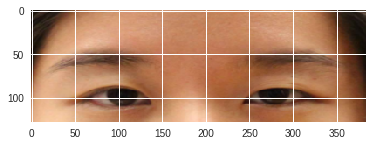

In [42]:
plt.imshow(X_test[73])
# plt.imshow(X_test[91])
# plt.imshow(X_test[119])
# plt.imshow(X_test[127])
# plt.imshow(X_test[129])

64
[array([[ 3.5205805, -1.173499 ]], dtype=float32)]
[0 0]
73
[array([[ 0.2359932, -0.6109543]], dtype=float32)]
[0 0]
91
[array([[-2.9576485,  4.945079 ]], dtype=float32)]
[0 0]
119
[array([[ 0.0680668 , -0.05850273]], dtype=float32)]
[0 0]
127
[array([[ 3.4833505, -2.388643 ]], dtype=float32)]
[0 0]
129
[array([[ 2.2776146, -1.9983251]], dtype=float32)]
[0 0]
133
[array([[ 0.26499742, -1.2275915 ]], dtype=float32)]
[0 0]
174
[array([[-3.3848627, -2.3872705]], dtype=float32)]
[0 0]


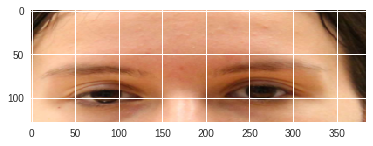

In [35]:
for i in range(len(y_test)):
  if y_test[i][0] == 0 and y_test[i][1] == 0:
    img_index = i

    plt.imshow(X_test[img_index])

    feed_dict = {
        image_input: [X_test[img_index]],
        is_training: False
    }

    prediction = sess.run([logits], feed_dict=feed_dict)

    print(i)
    print(prediction)
    print(y_test[img_index])




drive/Lic_Tests/image8.jpg
[array([[-3.0809672, -7.3731394]], dtype=float32)]


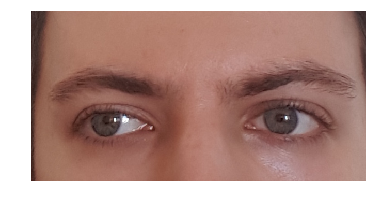

In [43]:
from PIL import Image

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

PATH_TO_TEST_IMAGES_DIR = 'drive/Lic_Tests'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 9) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

img_no = 7
for image_path in TEST_IMAGE_PATHS[img_no:img_no+1]:
  print(image_path)
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  
  image_np = cv2.resize(image_np, dsize=(384, 128))
  image_np = np.asarray(image_np.tolist())
  
  feed_dict = {
    image_input: [image_np],
    is_training: False
  }

  prediction = sess.run([logits], feed_dict=feed_dict)

  print(prediction)
  
  plt.axis('off')
  plt.imshow(image)

## Save a model checkpoint. Restoring a model checkpoint

In [50]:
[n.name for n in tf.get_default_graph().as_graph_def().node if n.name.find("output") != -1]


[]

In [51]:
!ls ..

backend-container
bin
boot
colabtools
content
datalab
dev
etc
gpu-tensorflow-1.6.0-cp27-cp27mu-linux_x86_64.whl
gpu-tensorflow-1.6.0-cp36-cp36m-linux_x86_64.whl
home
lib
lib64
media
mnt
node_modules
opt
proc
requirements.txt
root
run
sbin
srv
sys
tensorflow-1.6.0-cp27-cp27mu-linux_x86_64.whl
tensorflow-1.6.0-cp36-cp36m-linux_x86_64.whl
tf_deps
tmp
tools
usr
var


In [ ]:
# Create a simple TF Graph 
# Preparing a TF model for usage in Android
# By Omid Alemi - Jan 2017
# Works with TF r1.0

import tensorflow as tf
import sys
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

saver = tf.train.Saver()

# save the graph
tf.train.write_graph(sess.graph_def, './drive/eye_dataset_aux/', 'tfdroid.pbtxt')  

#save a checkpoint file, which will store the above assignment  
saver.save(sess, './drive/eye_dataset_aux/tfdroid.ckpt')
  
MODEL_NAME = 'tfdroid'
# Freeze the graph
input_graph_path = './drive/eye_dataset_aux/'+MODEL_NAME+'.pbtxt'
checkpoint_path = './drive/eye_dataset_aux/'+MODEL_NAME+'.ckpt'
input_saver_def_path = ""
input_binary = False
output_node_names = "EyeNet/eye_coordinates"
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = './drive/eye_dataset_aux/frozen_'+MODEL_NAME+'.pb'
output_optimized_graph_name = './drive/eye_dataset_aux/optimized_'+MODEL_NAME+'.pb'
clear_devices = True


freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                          input_binary, checkpoint_path, output_node_names,
                          restore_op_name, filename_tensor_name,
                          output_frozen_graph_name, clear_devices, "")



# Optimize for inference

input_graph_def = tf.GraphDef()
with tf.gfile.Open(output_frozen_graph_name, "rb") as f:
    data = f.read()
    input_graph_def.ParseFromString(data)
print(input_graph_def)
output_graph_def = optimize_for_inference_lib.optimize_for_inference(
        input_graph_def,
        ["image_input"], # an array of the input node(s)
        ["EyeNet/eye_coordinates"], # an array of output nodes
        tf.float32.as_datatype_enum)

# Save the optimized graph

f = tf.gfile.FastGFile(output_optimized_graph_name, "w")
f.write(output_graph_def.SerializeToString())

# tf.train.write_graph(output_graph_def, 'content/drive/eye_dataset/', output_optimized_graph_name)   